##Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from zipfile import ZipFile
file_name = ("/content/drive/MyDrive/CAPSTONE BANGKIT/DATASET/heypet_dataset3.zip")

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


##Import Library

In [6]:
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt

from shutil import copy
from google.colab import drive
from tensorflow.keras import layers
from collections import defaultdict
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

##Data Exploration

In [12]:
os.listdir('/content/heypet_dataset/test_dataset')

['test', 'val', 'train']

In [13]:
os.listdir('/content/heypet_dataset/test_dataset/test')

['goldenretriever',
 'labrador',
 'americanshorthair',
 'abyssinian',
 'persian',
 'chihuahua',
 'bulldog',
 'sphynx',
 'husky',
 'siamese']

In [8]:
os.listdir('/content/heypet_dataset/test_dataset/train')

['goldenretriever',
 'labrador',
 'americanshorthair',
 'abyssinian',
 'persian',
 'chihuahua',
 'bulldog',
 'sphynx',
 'husky',
 'siamese']

In [9]:
os.listdir('/content/heypet_dataset/test_dataset/val')

['goldenretriever',
 'labrador',
 'americanshorthair',
 'abyssinian',
 'persian',
 'chihuahua',
 'bulldog',
 'sphynx',
 'husky',
 'siamese']

In [7]:
train_dir = '/content/heypet_dataset/test_dataset/train'
validation_dir = '/content/heypet_dataset/test_dataset/val'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode = 'categorical',
                                             image_size = IMG_SIZE,
                                             batch_size = BATCH_SIZE,
                                             shuffle = True)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode ='categorical',
                                                  image_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True)


Found 2274 files belonging to 10 classes.
Found 197 files belonging to 10 classes.


Found 2274 files belonging to 10 classes.
['abyssinian', 'americanshorthair', 'bulldog', 'chihuahua', 'goldenretriever', 'husky', 'labrador', 'persian', 'siamese', 'sphynx']


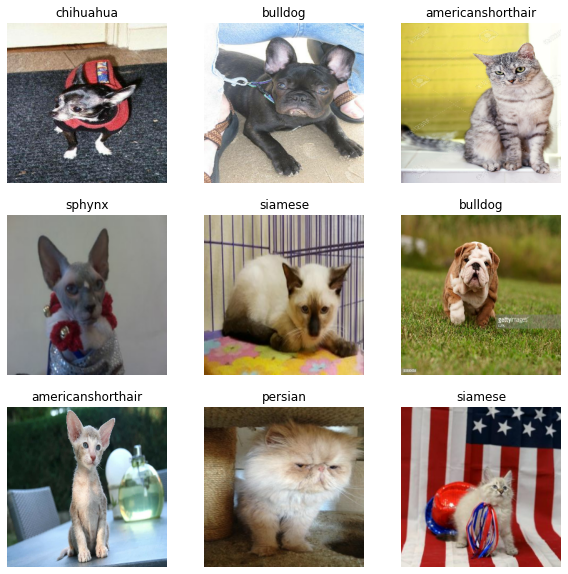

In [14]:
data = image_dataset_from_directory(train_dir)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Data Preprocessing

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

##Architecture

###Load MobileNetV2 Pretrained Model

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [18]:
feature, target = next(iter(train_dataset))
feature_batch = base_model(feature)
print(feature_batch.shape)

(32, 7, 7, 1280)


###Freeze Layer

In [19]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


###Create New Dense Layer

In [25]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)                  

x = layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x) 

model = tf.keras.Model(inputs, x)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

###Training Preperation

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

###Training

In [28]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[es_callback])

Epoch 1/100
72/72 [==============================] - 93s 1s/step - loss: 1.8494 - accuracy: 0.4305 - val_loss: 0.7743 - val_accuracy: 0.8667
Epoch 2/100
72/72 [==============================] - 79s 1s/step - loss: 0.9744 - accuracy: 0.7212 - val_loss: 0.5034 - val_accuracy: 0.8667
Epoch 3/100
72/72 [==============================] - 85s 1s/step - loss: 0.7714 - accuracy: 0.7762 - val_loss: 0.4588 - val_accuracy: 0.8788
Epoch 4/100
72/72 [==============================] - 81s 1s/step - loss: 0.6704 - accuracy: 0.8118 - val_loss: 0.3974 - val_accuracy: 0.8970
Epoch 5/100
72/72 [==============================] - 86s 1s/step - loss: 0.6476 - accuracy: 0.8140 - val_loss: 0.3926 - val_accuracy: 0.8909
Epoch 6/100
72/72 [==============================] - 79s 1s/step - loss: 0.5917 - accuracy: 0.8333 - val_loss: 0.3846 - val_accuracy: 0.8909
Epoch 7/100
72/72 [==============================] - 79s 1s/step - loss: 0.5830 - accuracy: 0.8474 - val_loss: 0.4207 - val_accuracy: 0.8848
Epoch 8/100
7

###Plot Loss And Accuracy

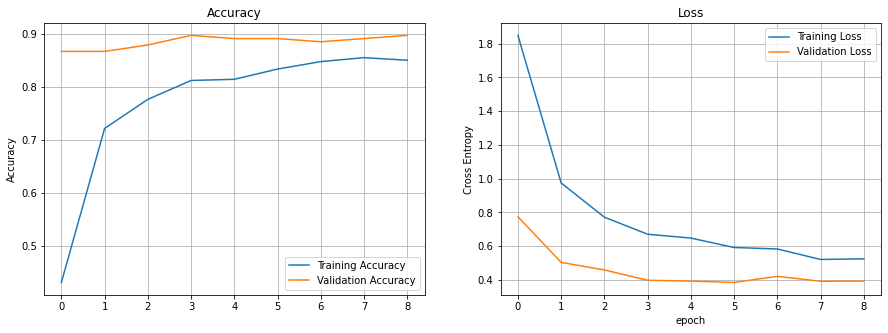

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

###Fine Tuning

In [30]:
base_model.trainable = True

In [31]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [34]:
fine_tune_epochs = 100
total_epochs =  21 + fine_tune_epochs
print(total_epochs)

121


In [35]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es_callback])

Epoch 9/121
72/72 [==============================] - 119s 2s/step - loss: 0.4857 - accuracy: 0.8659 - val_loss: 0.4141 - val_accuracy: 0.8970
Epoch 10/121
72/72 [==============================] - 110s 1s/step - loss: 0.4488 - accuracy: 0.8848 - val_loss: 0.3686 - val_accuracy: 0.9152
Epoch 11/121
72/72 [==============================] - 109s 1s/step - loss: 0.4329 - accuracy: 0.8865 - val_loss: 0.3665 - val_accuracy: 0.9091
Epoch 12/121
72/72 [==============================] - 110s 1s/step - loss: 0.4053 - accuracy: 0.9011 - val_loss: 0.4041 - val_accuracy: 0.8848
Epoch 13/121
72/72 [==============================] - 109s 1s/step - loss: 0.4055 - accuracy: 0.8887 - val_loss: 0.3366 - val_accuracy: 0.9152
Epoch 14/121
72/72 [==============================] - 109s 1s/step - loss: 0.3982 - accuracy: 0.8975 - val_loss: 0.3998 - val_accuracy: 0.9030
Epoch 15/121
72/72 [==============================] - 108s 1s/step - loss: 0.3676 - accuracy: 0.9041 - val_loss: 0.3458 - val_accuracy: 0.9212


In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

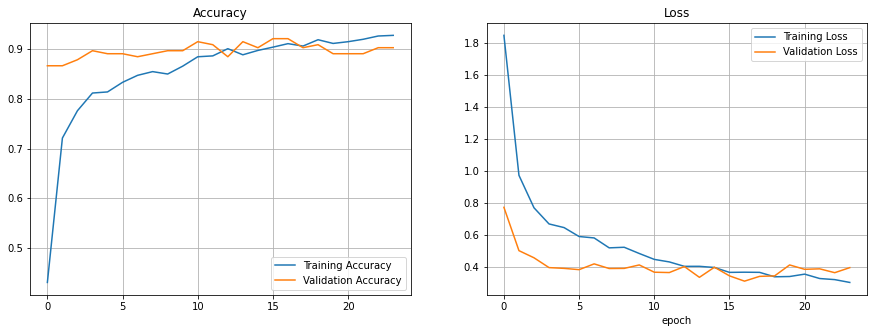

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.3478 - accuracy: 0.9375
Test accuracy : 0.9375


In [39]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/CAPSTONE BANGKIT/Save_model.h5')

###Convert To Tensorflow Lite

In [40]:
tflite_model = tf.keras.models.load_model('/content/drive/MyDrive/CAPSTONE BANGKIT/Save_model/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("/content/drive/MyDrive/CAPSTONE BANGKIT/Save_model.tflite", "wb").write(tflite_save)

16750920